In [1]:
import numpy as np
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import os
import importlib

importlib.reload(pyuvdata)
from IPython.display import Image
from newcal import (
    caldata,
    calibration_wrappers,
    calibration_optimization,
    cost_function_calculations,
)
import plot_delay_spectra

In [2]:
abscal_params = np.load("/safepool/rbyrne/hera_abscal_Aug2024/abscal_params.npy")
dwabscal_params = np.load("/safepool/rbyrne/hera_abscal_Jul2024/dwabscal_params.npy")

In [3]:
print(np.shape(abscal_params))

(3, 1536, 1)


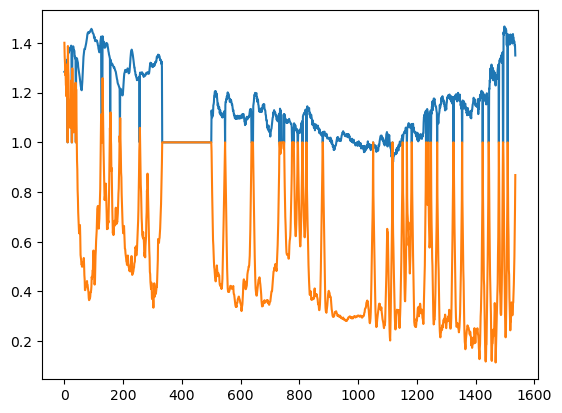

In [4]:
plt.plot(abscal_params[0, :, 0])
plt.plot(dwabscal_params[0, :, 0])
# plt.ylim([0,1.3])
plt.show()

In [5]:
np.mean(abscal_params[0, :, 0] / dwabscal_params[0, :, 0])

2.5311196779651155

In [6]:
data_orig = pyuvdata.UVData()
data_orig.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
model = pyuvdata.UVData()
model.read(
    "/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
)
data_abscal = pyuvdata.UVData()
data_abscal.read("/safepool/rbyrne/hera_abscal_Jul2024/abscal_data.uvfits")
data_dwabscal = pyuvdata.UVData()
data_dwabscal.read("/safepool/rbyrne/hera_abscal_Jul2024/dwabscal_data.uvfits")

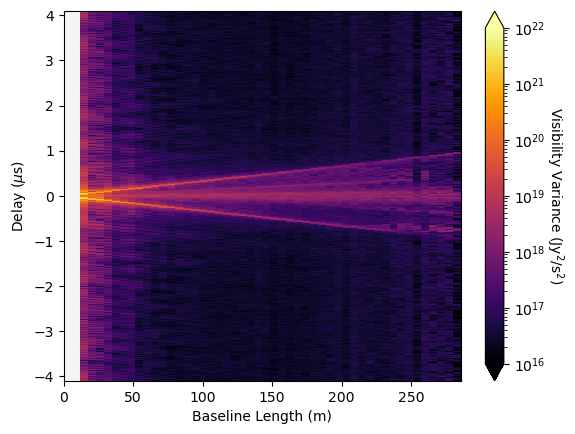

In [7]:
plot_delay_spectra.plot_visibilities(data_orig)

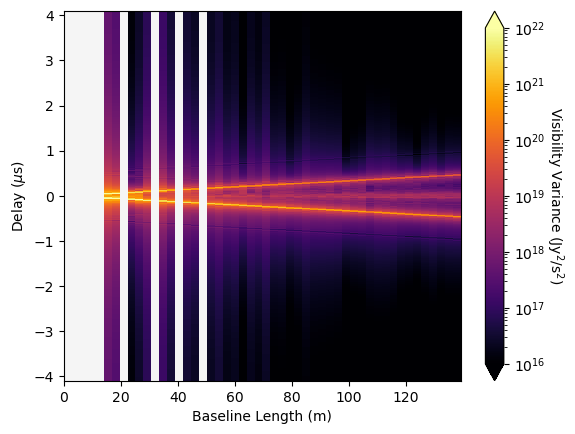

In [8]:
plot_delay_spectra.plot_visibilities(model)

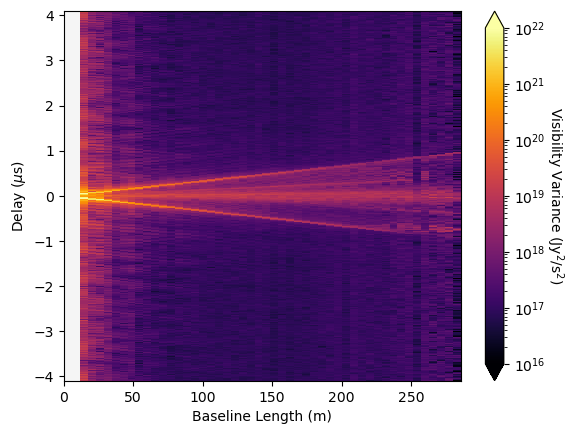

In [9]:
plot_delay_spectra.plot_visibilities(data_abscal)

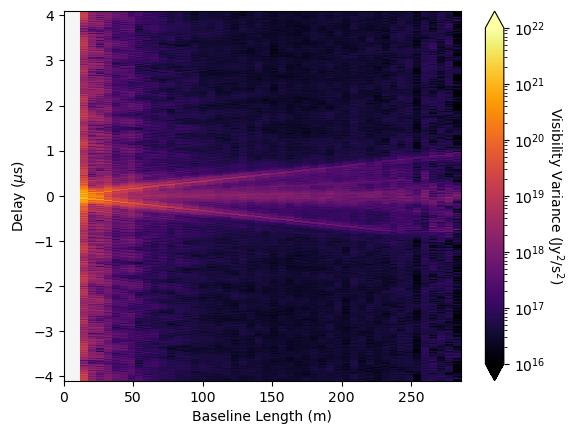

In [10]:
plot_delay_spectra.plot_visibilities(data_dwabscal)

In [14]:
# Calculate difference

nbins=100
use_pol=-5
model.inflate_by_redundancy(use_grid_alg=True)
bl_lengths = np.sqrt(np.sum(model.uvw_array**2.0, axis=1))
data = data_orig
data.inflate_by_redundancy(use_grid_alg=True)
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
data.select(bls=use_baselines, polarizations=use_pol)
model.select(bls=use_baselines, polarizations=use_pol)
# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))
# Ensure ordering matches
data.reorder_blts()
model.reorder_blts()
data.reorder_pols(order="AIPS")
model.reorder_pols(order="AIPS")
data.reorder_freqs(channel_order="freq")
model.reorder_freqs(channel_order="freq")
data.filename = [""]
model.filename = [""]
diff = data.sum_vis(
    model,
    difference=True,
    inplace=False,
    override_params=[
        "nsample_array",
        "earth_omega",
        "flag_array",
        "filename",
        "phase_center_catalog",
        "timesys",
        "uvw_array",
        "phase_center_app_ra",
        "phase_center_app_dec",
        "phase_center_frame_pa",
        "vis_units",
        "lst_array",
        "time_array",
        "rdate",
        "dut1",
        "telescope",
        "phase_center_id_array",
        "gst0"
    ],
)
diff.flag_array = data.flag_array
bl_lengths = np.sqrt(np.sum(diff.uvw_array**2.0, axis=1))
use_data_diff = np.copy(diff.data_array[:, :, 0])
use_data_diff[np.where(diff.flag_array[:, :, 0])] = 0  # Zero out flagged data
use_data = np.copy(data.data_array[:, :, 0])
use_data[np.where(data.flag_array[:, :, 0])] = 0

baseline_all_flagged = np.min(
    diff.flag_array, axis=(1, 2,)
)  # Note what baselines are fully flagged

channel_width = np.mean(diff.channel_width)
frequencies = diff.freq_array.flatten()
delay_array = np.fft.fftshift(np.fft.fftfreq(diff.Nfreqs, d=channel_width))
bl_bin_edges = np.linspace(0, np.max(bl_lengths), num=nbins + 1)
binned_variance_diff = np.full([nbins, len(frequencies)], 0.0, dtype="float")
binned_variance = np.full([nbins, len(frequencies)], 0.0, dtype="float")
nsamples = np.full([nbins, len(frequencies)], 0.0, dtype="float")

fft_abs_diff = np.abs(np.fft.fftshift(np.fft.fft(use_data_diff, axis=1), axes=1))
fft_abs_diff *= channel_width
fft_abs = np.abs(np.fft.fftshift(np.fft.fft(use_data, axis=1), axes=1))
fft_abs *= channel_width

for bin_ind in range(nbins):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        & (~baseline_all_flagged)
    )[0]
    if len(bl_inds) > 0:
        binned_variance_diff[bin_ind, :] += np.sum(
            fft_abs_diff[bl_inds, :] ** 2.0, axis=0
        )
        binned_variance[bin_ind, :] += np.sum(
            fft_abs[bl_inds, :] ** 2.0, axis=0
        )
        nsamples[bin_ind, :] += len(bl_inds)

mean_variance_diff = binned_variance_diff / nsamples
mean_variance_data = binned_variance / nsamples

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.
The entry name zenith_at_jd2459861.450044 is not unique inside the phase center catalog, adding anyways.
invalid value encountered in divide
invalid value encountered in divide


In [29]:
print(np.shape(diff.data_array))
print(np.shape(data.data_array))
ratio = np.abs(diff.data_array) / np.abs(data.data_array)
ratio[np.where(data.data_array == 0.)] = np.nan
print(np.nanmean(ratio))

(52418, 1536, 1)
(52418, 1536, 1)


divide by zero encountered in divide


2.3809445429005667


In [36]:
data_binned = np.zeros([nbins], dtype="float")
diff_binned = np.zeros([nbins], dtype="float")
nsamples = np.zeros([nbins], dtype="int")
for bin_ind in range(nbins):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        & (~baseline_all_flagged)
    )[0]
    if len(bl_inds) > 0:
        diff_binned[bin_ind] += np.sum(
            np.abs(diff.data_array[bl_inds, :, 0]) ** 2.0
        )
        data_binned[bin_ind] += np.sum(np.abs(data.data_array[bl_inds, :, 0]) ** 2.0)
        nsamples[bin_ind] += len(bl_inds)
diff_binned /= nsamples
data_binned /= nsamples

invalid value encountered in divide
invalid value encountered in divide


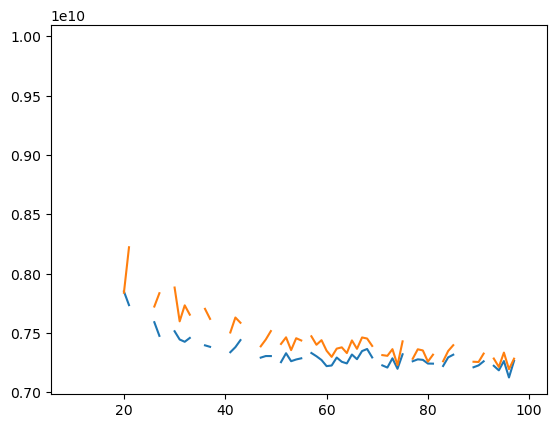

In [40]:
plt.plot(data_binned)
plt.plot(diff_binned)
plt.show()

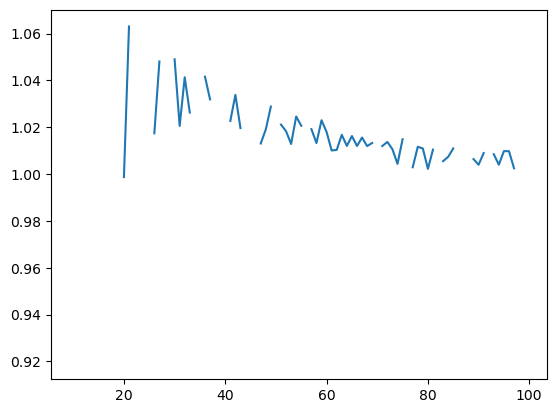

In [38]:
plt.plot(diff_binned/data_binned)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


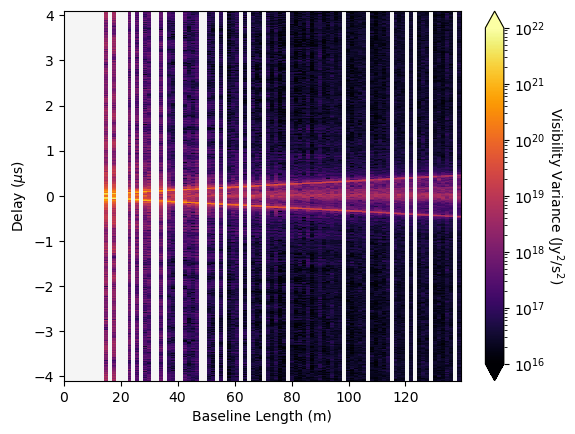

In [18]:
vmin=1e16
vmax=1e22
xmin = np.min(bl_lengths)
xmax = np.max(bl_lengths)
use_cmap = matplotlib.cm.get_cmap("inferno")
use_cmap.set_bad(color="whitesmoke")
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ymin = np.min(delay_array) * 1e6
ymax = np.max(delay_array) * 1e6
plt.imshow(
    mean_variance_data.T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    extent=[
        xmin,
        xmax,
        ymin,
        ymax,
    ],
    aspect="auto",
)

cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel(
    "Visibility Variance (Jy$^{2}$/s$^2$)", rotation=270, labelpad=15
)
plt.xlabel("Baseline Length (m)")
plt.ylim([np.min(delay_array) * 1e6, np.max(delay_array) * 1e6])
plt.ylabel("Delay ($\mu$s)")
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


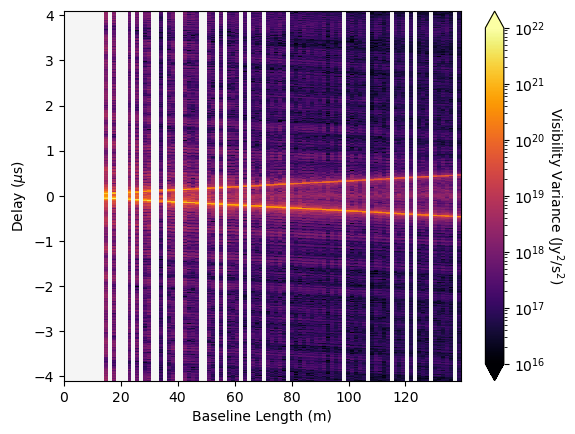

In [19]:
vmin = 1e16
vmax = 1e22
xmin = np.min(bl_lengths)
xmax = np.max(bl_lengths)
use_cmap = matplotlib.cm.get_cmap("inferno")
use_cmap.set_bad(color="whitesmoke")
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ymin = np.min(delay_array) * 1e6
ymax = np.max(delay_array) * 1e6
plt.imshow(
    mean_variance_diff.T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    extent=[
        xmin,
        xmax,
        ymin,
        ymax,
    ],
    aspect="auto",
)

cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel("Visibility Variance (Jy$^{2}$/s$^2$)", rotation=270, labelpad=15)
plt.xlabel("Baseline Length (m)")
plt.ylim([np.min(delay_array) * 1e6, np.max(delay_array) * 1e6])
plt.ylabel("Delay ($\mu$s)")
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


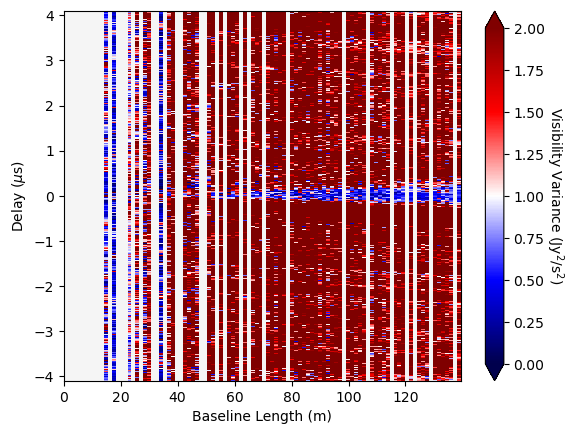

In [24]:
vmin = 0
vmax = 2
xmin = np.min(bl_lengths)
xmax = np.max(bl_lengths)
use_cmap = matplotlib.cm.get_cmap("seismic")
use_cmap.set_bad(color="whitesmoke")
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
ymin = np.min(delay_array) * 1e6
ymax = np.max(delay_array) * 1e6
plt.imshow(
    (mean_variance_diff/mean_variance_data).T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    extent=[
        xmin,
        xmax,
        ymin,
        ymax,
    ],
    aspect="auto",
)

cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel("Visibility Variance (Jy$^{2}$/s$^2$)", rotation=270, labelpad=15)
plt.xlabel("Baseline Length (m)")
plt.ylim([np.min(delay_array) * 1e6, np.max(delay_array) * 1e6])
plt.ylabel("Delay ($\mu$s)")
plt.show()